In [1]:
import pandas as pd
from __future__ import absolute_import, division

import os
import time
import numpy as np
import pandas as pd
import gensim
from tqdm import tqdm
import random
import psutil
from multiprocessing import Pool
import multiprocessing as mp
from gensim.models import KeyedVectors
import re
import gc
import pickle
import operator

In [2]:
def set_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']= str(seed)
    np.random.seed(seed)
    
set_seed(2019)
SEED = 42
num_partitions = 8
num_cores = psutil.cpu_count()

print('number of cores: ',num_cores)

def df_parallelize_run(df,func):
    df_split = np.array_split(df,num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func,df_split))
    pool.close()
    pool.join()
    return df

number of cores:  16


In [3]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')


def load_embeddings(path):
    embeddings_index = {}
    f = open(path,encoding='utf8')
    print(f)
    for line in f:
        values = line.split()
        word = ' '.join(values[:-300])
        coefs = np.asarray(values[-300:], dtype='float32')
        embeddings_index[word] = coefs.reshape(-1)
    f.close()
    return embeddings_index

def build_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    unknown_words = []
    
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            unknown_words.append(word)
    return embedding_matrix, unknown_words


In [4]:
def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
#     sentences=str(sentences)
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x


In [5]:
GLOVE_EMBEDDING_PATH= "glove/glove6B/glove.6B.300d.txt"
num_models = 2
lstm_units = 128
dense_hidden_units = 4 * lstm_units
max_len = 220
embed_size = 300
max_features = 120000

In [6]:
tic = time.time()
glove_embeddings = load_embeddings(GLOVE_EMBEDDING_PATH)
print(f'loaded {len(glove_embeddings)} word vectors in {time.time()-tic}s')

<_io.TextIOWrapper name='glove/glove6B/glove.6B.300d.txt' mode='r' encoding='utf8'>
loaded 400001 word vectors in 24.664456367492676s


In [7]:
# %%time
# load = True
# if not load:
train=pd.read_csv("LIAR-PLUS/dataset/train.tsv",delimiter='\t',header=None,error_bad_lines=False)
test=pd.read_csv("LIAR-PLUS/dataset/test.tsv",delimiter='\t',header=None,error_bad_lines=False)
valid=pd.read_csv("LIAR-PLUS/dataset/valid.tsv",delimiter='\t',header=None,error_bad_lines=False)
train.dropna()

b'Skipping line 548: expected 15 fields, saw 16\nSkipping line 9088: expected 15 fields, saw 27\nSkipping line 9812: expected 15 fields, saw 27\n'
b'Skipping line 458: expected 15 fields, saw 16\n'


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up.Anni...
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...
5,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece,"But Vos specifically used the word ""fired,"" wh..."
7,153.json,half-true,I'm the only person on this stage who has work...,ethics,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,"a Democratic debate in Philadelphia, Pa.","However, it was not that bill, but another one..."
9,9741.json,mostly-true,Says GOP primary opponents Glenn Grothman and ...,"energy,message-machine-2014,voting-record",duey-stroebel,State representative,Wisconsin,republican,0.0,0.0,0.0,1.0,0.0,an online video,Considering that the $532 million figure cover...
10,7115.json,mostly-true,"For the first time in history, the share of th...",elections,robert-menendez,U.S. Senator,New Jersey,democrat,1.0,3.0,1.0,3.0,0.0,a speech,The senator’s correct that Latino voters put O...
11,4148.json,half-true,"Since 2000, nearly 12 million Americans have s...","economy,jobs,new-hampshire-2012,poverty",bernie-s,U.S. Senator,Vermont,independent,18.0,12.0,22.0,41.0,0.0,a tweet,"So where does this leave us?On Sanders’ side, ..."
14,8705.json,barely-true,Most of the (Affordable Care Act) has already ...,health-care,george-will,Columnist,Maryland,columnist,7.0,6.0,3.0,5.0,1.0,"comments on ""Fox News Sunday""",With all the talk about problems with the heal...
15,10683.json,half-true,"In this last election in November, ... 63 perc...",elections,bernie-s,U.S. Senator,Vermont,independent,18.0,12.0,22.0,41.0,0.0,"a town hall in Austin, Texas","Sanders said that ""in this last election in No..."


In [8]:
train[14]

0        That's a premise that he fails to back up.Anni...
1        Surovell said the decline of coal "started whe...
2        Obama said he would have voted against the ame...
3        The release may have a point that Mikulski’s c...
4        Crist said that the economic "turnaround start...
5        But Vos specifically used the word "fired," wh...
6        But determining that would take significant de...
7        However, it was not that bill, but another one...
8        But Johnson is correct that many other factors...
9        Considering that the $532 million figure cover...
10       The senator’s correct that Latino voters put O...
11       So where does this leave us?On Sanders’ side, ...
12                                                     NaN
13       Doonesbury, aka Garry Trudeau, said the govern...
14       With all the talk about problems with the heal...
15       Sanders said that "in this last election in No...
16       I firmly object to all 'buy America' restricti.

In [9]:
vocab = build_vocab(list(train[14].apply(lambda x:str(x).split())))
oov = check_coverage(vocab,glove_embeddings)
oov[:10]

100%|██████████| 69200/69200 [00:00<00:00, 1269450.25it/s]

Found embeddings for 23.88% of vocab
Found embeddings for  78.60% of all text


[('Obama', 1428),
 ('The', 1298),
 ('said,', 1099),
 ('it’s', 887),
 ('U.S.', 842),
 ('Clinton', 745),
 ('United', 674),
 ('Trump', 632),
 ("it's", 552),
 ('But', 521)]

In [10]:
import string
def text_to_wordlist(text, remove_stopwords=False,stem_words=False,lemma_word=False):
    
    text = str(text)
    text = text.split()
    
    #remove stops
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        
    text = " ".join(text)
    
    #clean text 
#     text = re.sub(r"'s ", " is ", text)
#     text = re.sub(r"’s ", " is ", text)
    text = re.sub(r",",r"",text)
    #text = re.sub(r"u.s", "us", text)
#     text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(u'\xa0', u' ',text)
#     text = re.sub(r",", "", text)
#     text = re.sub(r"\.", " ", text)
#     text = re.sub(r"!", " ! ", text)
#     text = re.sub(r"\/", " ", text)
#     text = re.sub(r"\^", " ^ ", text)
#     text = re.sub(r"\+", " + ", text)
#     text = re.sub(r"\-", " - ", text)
#     text = re.sub(r"\=", " = ", text)
#     text = re.sub(r"'", " ", text)
#     text = re.sub(r"\"", " ", text)
#     text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
#     text = re.sub(r":", " : ", text)
    text=re.sub(r"\'",r"'",text)
    text = re.sub(r" e.g ", " eg ", text)
    text = re.sub(r" b.g ", " bg ", text)
    text = re.sub(r"U.S", "US", text)
#     text = re.sub(r";", "", text)
    text = re.sub(r"sharethefacts{.*?Share The Facts"," ",text)
    
    # stemmer
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
        
    
        
    return text





In [11]:
data_train = train[14].apply(lambda x: text_to_wordlist(x))
# data_train=list(data_train)
# data_train

In [12]:

vocab = build_vocab(list(data_train.apply(lambda x:str(x).split())))
oov = check_coverage(vocab,glove_embeddings)
oov[:50]

100%|██████████| 63225/63225 [00:00<00:00, 1251438.72it/s]

Found embeddings for 26.69% of vocab
Found embeddings for  82.26% of all text


[('Obama', 1494),
 ('The', 1294),
 ('it’s', 887),
 ('US.', 855),
 ('Clinton', 781),
 ('United', 675),
 ('Trump', 655),
 ("it's", 552),
 ('But', 534),
 ('Republican', 506),
 ('New', 502),
 ('Texas', 477),
 ('House', 477),
 ('States', 475),
 ('Florida', 461),
 ('Senate', 452),
 ('doesn’t', 447),
 ('didn’t', 443),
 ('Romney', 435),
 ('In', 433),
 ('Bush', 400),
 ('Congress', 397),
 ('Americans', 382),
 ('Democrats', 359),
 ('I', 359),
 ('don’t', 356),
 ('American', 345),
 ('Republicans', 341),
 ('that’s', 320),
 ('Democratic', 318),
 ('Our', 314),
 ('Medicare', 296),
 ('"the', 293),
 ('We', 283),
 ('Scott', 281),
 ('Obama’s', 280),
 ('Department', 279),
 ('Walker', 274),
 ('McCain', 274),
 ('there’s', 271),
 ("don't", 266),
 ('State', 243),
 ("doesn't", 243),
 ('A', 235),
 ('Rubio', 234),
 ('state’s', 229),
 ('Perry', 229),
 ('Security', 225),
 ("Obama's", 225),
 ("didn't", 216)]

In [13]:
import string
latin_similar = "’'‘ÆÐƎƏƐƔĲŊŒẞÞǷȜæðǝəɛɣĳŋœĸſßþƿȝĄƁÇĐƊĘĦĮƘŁØƠŞȘŢȚŦŲƯY̨Ƴąɓçđɗęħįƙłøơşșţțŧųưy̨ƴÁÀÂÄǍĂĀÃÅǺĄÆǼǢƁĆĊĈČÇĎḌĐƊÐÉÈĖÊËĚĔĒĘẸƎƏƐĠĜǦĞĢƔáàâäǎăāãåǻąæǽǣɓćċĉčçďḍđɗðéèėêëěĕēęẹǝəɛġĝǧğģɣĤḤĦIÍÌİÎÏǏĬĪĨĮỊĲĴĶƘĹĻŁĽĿʼNŃN̈ŇÑŅŊÓÒÔÖǑŎŌÕŐỌØǾƠŒĥḥħıíìiîïǐĭīĩįịĳĵķƙĸĺļłľŀŉńn̈ňñņŋóòôöǒŏōõőọøǿơœŔŘŖŚŜŠŞȘṢẞŤŢṬŦÞÚÙÛÜǓŬŪŨŰŮŲỤƯẂẀŴẄǷÝỲŶŸȲỸƳŹŻŽẒŕřŗſśŝšşșṣßťţṭŧþúùûüǔŭūũűůųụưẃẁŵẅƿýỳŷÿȳỹƴźżžẓ"
white_list = string.ascii_letters + string.digits + latin_similar + ' '
white_list += "'"


In [14]:
glove_chars = ''.join([c for c in tqdm(glove_embeddings) if len(c) == 1])
glove_symbols = ''.join([c for c in glove_chars if not c in white_list])
glove_symbols

100%|██████████| 400001/400001 [00:00<00:00, 3053814.15it/s]


',."-():$;_?–%/!`&=—“”#[+¥£|]~\\{…½>€}*@<»«、α¼^βφωλσδγθπ„με¾¡ρ¢ψτηƒκ₤⅓иνζ¿χξ⅔в―ο。‚сιರа⅛རསυя›ಕངоو‹уನ˚ದනгරאеತಸകಮ⅜ག₂ව·ಪල¤ὁදкසವಗіរ⅝කལϕནདಲтಯಡಬ¨ъടම‟мಶь⅞ה镇පයнªམ乡තлಟབпសಹ道ɔରതф￥ר王хἡчэзപʃḳшיוಳបʔកбדග⁰дಜש李жєבតס神姬人一ю'

In [15]:
jigsaw_chars = build_vocab(list(data_train))
jigsaw_symbols = ''.join([c for c in jigsaw_chars if not c in white_list])
jigsaw_symbols

100%|██████████| 10243/10243 [00:00<00:00, 30193.81it/s]


'.-"…()“”;$?:—–/%*@\u202a#\u200e\u202c&!•[]+{}_=`½➤\\\xad―⅔'

In [16]:
symbols_to_delete = ''.join([c for c in jigsaw_symbols if not c in glove_symbols])
symbols_to_delete

'\u202a\u200e\u202c•➤\xad'

In [17]:
symbols_to_isolate = ''.join([c for c in jigsaw_symbols if c in glove_symbols])
symbols_to_isolate

'.-"…()“”;$?:—–/%*@#&![]+{}_=`½\\―⅔'

In [18]:
isolate_dict = {ord(c):f' {c} ' for c in symbols_to_isolate}
remove_dict = {ord(c):f'' for c in symbols_to_delete}


def handle_punctuation(x):
    x=str(x)
    x = x.translate(remove_dict)
    x = x.translate(isolate_dict)
    return x

In [19]:
data_train = data_train.apply(lambda x: handle_punctuation(x))
# data_train

In [20]:
vocab = build_vocab(list(data_train.apply(lambda x:x.split())))
oov = check_coverage(vocab,glove_embeddings)
oov[:10]


100%|██████████| 28238/28238 [00:00<00:00, 1272003.14it/s]

Found embeddings for 59.04% of vocab
Found embeddings for  87.09% of all text


[('The', 4916),
 ('But', 3589),
 ('Obama', 1753),
 ('In', 1599),
 ('And', 1424),
 ('We', 1226),
 ('US', 955),
 ('Clinton', 938),
 ('it’s', 898),
 ('Trump', 817)]

In [21]:
from nltk.tokenize.treebank import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()

In [22]:
def handle_contractions(x):
    x = tokenizer.tokenize(x)
    x = ' '.join(x)
    return x

In [23]:
data_train = data_train.apply(lambda x: handle_contractions(x))

In [24]:
vocab = build_vocab(list(data_train.apply(lambda x:x.split())))
oov = check_coverage(vocab,glove_embeddings)
oov[:10]



100%|██████████| 25691/25691 [00:00<00:00, 1288236.90it/s]

Found embeddings for 65.09% of vocab
Found embeddings for  88.65% of all text


[('The', 4916),
 ('But', 3589),
 ('Obama', 2319),
 ('In', 1599),
 ('We', 1436),
 ('And', 1424),
 ('It', 1330),
 ('That', 1183),
 ('Clinton', 1143),
 ('Trump', 991)]

In [26]:
def preprocess(x):
    x = text_to_wordlist(x)
    x = handle_punctuation(x)
    x = handle_contractions(x)
    return x

In [28]:
len(oov)

8968

In [60]:
voc =[]
for x in oov[:10]:
    voc.append(x[0].lower())

In [51]:
w2v = load_embeddings(GLOVE_EMBEDDING_PATH)

<_io.TextIOWrapper name='glove/glove6B/glove.6B.300d.txt' mode='r' encoding='utf8'>


In [61]:
#visualization
def return_matrix(random_words,dim =300):
    word_matrix = np.random.randn(len(random_words),dim)
    i = 0
    for word in random_words:
        word_matrix[i] = w2v[word]
        i +=1
    return word_matrix

In [62]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

In [63]:
random_words = voc
return_matrix_ = return_matrix(random_words)
pca_ = PCA(n_components=2)
viz_data = pca_.fit_transform(return_matrix_) 

In [64]:
plt.scatter(viz_data[:,0],viz_data[:,1],cmap=plt.get_cmap('Spectral'))
for label,x,y in zip(random_words,viz_data[:,0],viz_data[:,1]):
    plt.annotate(
        label,
        xy=(x,y),
        xytext=(-14, 14),
        textcoords='offset points',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0')
    )
plt.xlabel('PCA Component 1 ')
plt.ylabel('PCA Component 2')
plt.title('PCA representation for Word Embedding')
plt.xlim(-10,10)
plt.ylim(-5,6)

(-5, 6)

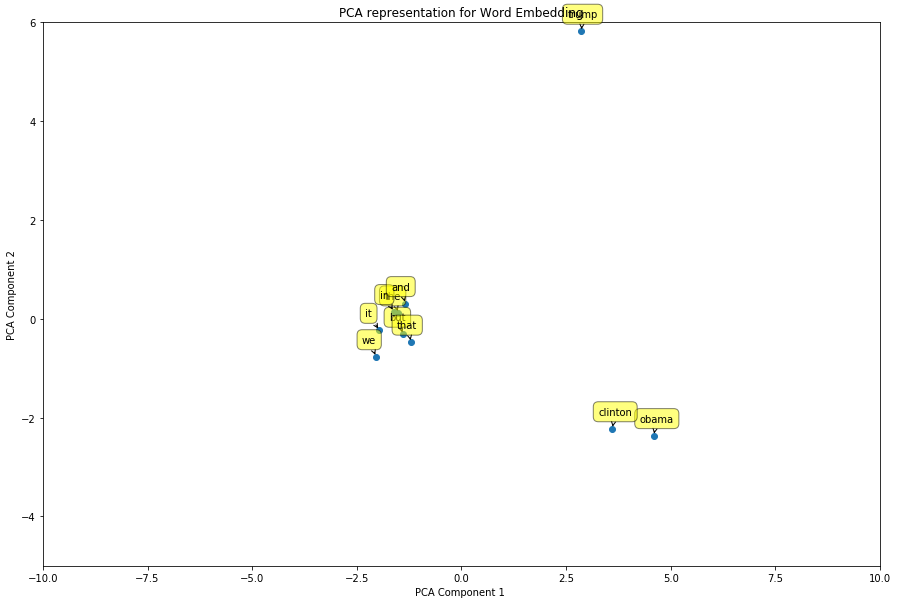

In [65]:
plt.show()

In [66]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1,perplexity=3,method='exact')
tsne_results = tsne.fit_transform(return_matrix_)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 10 / 10
[t-SNE] Mean sigma: 1.586763
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.108301
[t-SNE] Error after 1000 iterations: 0.149490


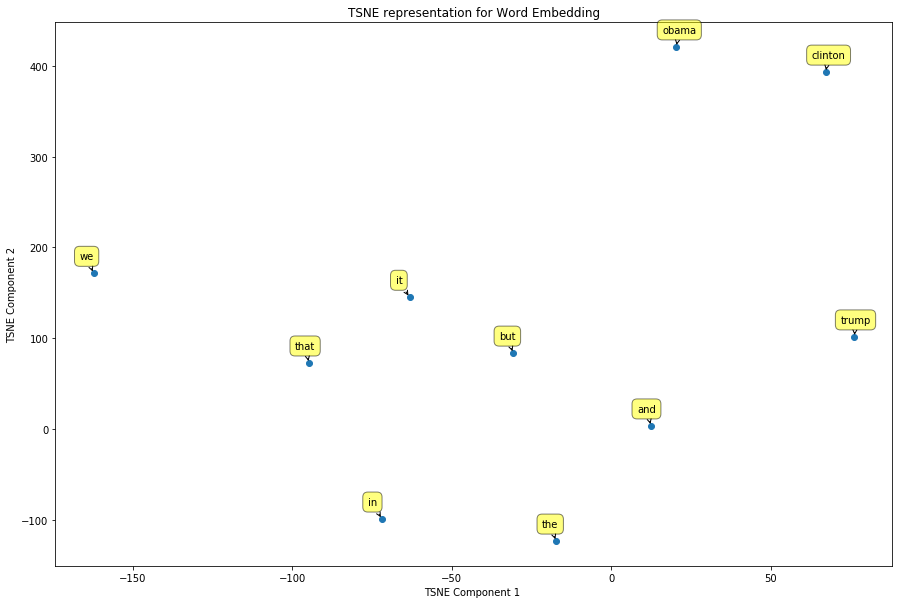

In [67]:
plt.scatter(tsne_results[:,0],tsne_results[:,1],cmap=plt.get_cmap('Spectral'))
for label,x,y in zip(random_words,tsne_results[:,0],tsne_results[:,1]):
    plt.annotate(
        label,
        xy=(x,y),
        xytext=(-14, 14),
        textcoords='offset points',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0')
    )
plt.xlabel('TSNE Component 1 ')
plt.ylabel('TSNE Component 2')
plt.title('TSNE representation for Word Embedding')
plt.show()